# CALSNIC Dataset

In [65]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utility.survival import (split_time_event, make_stratified_split,
                              convert_to_structured, make_event_times)

from utility.plot import load_tf_color
TFColor = load_tf_color()

date_cols = ['Visit_Date', 'CNSLS_Date', 'Date of death', 'ALSFRS_Date', 'SymptomOnset_Date']
file_name = "data_walking.csv"
df = pd.read_csv(Path.joinpath(cfg.DATA_DIR, file_name), index_col=0, parse_dates=date_cols)
df = df.loc[df['Diagnosis'] == 'ALS']
df = df.rename({'Event_ALSFRS_8_Walking': 'Event'}, axis=1)

In [66]:
df.head()

,PSCID,Visit Label,Symptom_Duration,Visit_details,Visit_Date,CNSLS_Date,CNSLS_TotalScore,Status,Date of death,Cause of death,...,Diagnosis,Sex,Age,SymptomOnset_Date,Region_of_Onset,Visit_Diff,SymptomDays,DiseaseProgressionRate,Event,TTE
0,CAL010,Visit 1,12.966667,NaN,2018-04-25,2018-04-25 00:00:00,11.0,Alive,NaT,NaN,...,ALS,Male,34,2017-04-01,upper_extremity,0,389.0,0.308483,0.0,127.0
1,CAL010,Visit 2,NaN,NaN,2018-08-30,NaN,NaN,Alive,NaT,NaN,...,ALS,Male,34,2017-04-01,upper_extremity,127,516.0,0.348837,0.0,127.0
2,CAL013,Visit 1,9.066667,NaN,2018-07-31,2018-08-07 00:00:00,10.0,Deceased,2020-01-19,Complications of ALS-respiratory,...,ALS,Female,64,2017-11-01,upper_extremity,0,272.0,1.323529,1.0,133.0
3,CAL013,Visit 2,NaN,NaN,2018-12-11,NaN,NaN,Deceased,2020-01-19,Complications of ALS-respiratory,...,ALS,Female,64,2017-11-01,upper_extremity,133,405.0,1.185185,1.0,125.0
4,CAL020,Visit 1,22.066667,NaN,2019-02-22,2019-02-22 00:00:00,7.0,Alive,NaT,NaN,...,ALS,Male,46,2017-05-01,lower_extremity,0,662.0,0.135952,0.0,132.0


In [67]:
obs_arr = np.array(df['Event'])
n_censored = obs_arr.shape[0] - obs_arr.sum()
print(f"Number of samples: {len(df)}")
print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 92
Number of censored/uncensored: 62.0/30.0
67.39% of records are censored



In [68]:
# Load data
X = df.drop(['Event', 'TTE'], axis=1)
y = np.array(list(tuple(x) for x in df[['Event', 'TTE']].to_numpy()),
             dtype=[('Event', 'bool'), ('TTE', '<f8')])

# Select features
X = X[['Symptom_Duration', 'CNSLS_TotalScore', 'TAP_Fingertapping_Right_avg',
       'TAP_Fingertapping_Left_avg', 'TAP_Foottapping_Right_avg',
       'TAP_Foottapping_Left_avg', 'UMN_Right', 'UMN_Left', 'Age', 'SymptomDays']]
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(['object']).columns.tolist()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
feature_names = X_train.columns

# Preprocess data
from tools.preprocessor import Preprocessor
preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean', scaling_strategy="minmax")
transformer = preprocessor.fit(X_train, cat_feats=cat_features, num_feats=num_features,
                               one_hot=True, fill_value=-1)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [69]:
X_train

,Symptom_Duration,CNSLS_TotalScore,TAP_Fingertapping_Right_avg,TAP_Fingertapping_Left_avg,TAP_Foottapping_Right_avg,TAP_Foottapping_Left_avg,UMN_Right,UMN_Left,Age,SymptomDays
0,0.194956,0.000000,0.822222,0.658730,0.608696,0.490741,0.367816,0.472414,0.454545,0.186162
1,0.247226,0.235937,0.651852,0.500000,0.304348,0.425926,0.367816,0.472414,0.818182,0.139526
2,0.225781,0.235937,0.586032,0.515873,0.451776,0.498957,0.333333,0.600000,0.854545,0.215596
3,0.138110,0.450000,0.725926,0.801587,0.021739,0.259259,0.166667,0.200000,0.727273,0.131881
4,0.000000,0.235937,0.533333,0.531746,0.489130,0.555556,0.166667,0.200000,0.218182,0.000000
...,...,...,...,...,...,...,...,...,...,...
68,0.107686,0.100000,0.444444,0.301587,0.445652,0.500000,0.333333,0.400000,0.400000,0.102829
69,0.379904,0.050000,0.785185,0.555556,0.489130,0.509259,0.666667,0.800000,0.781818,0.362768
70,0.667734,0.050000,0.725926,0.595238,0.434783,0.490741,0.166667,0.200000,0.818182,0.637615
71,0.247226,0.235937,0.586032,0.515873,0.451776,0.498957,0.367816,0.472414,0.236364,0.264074


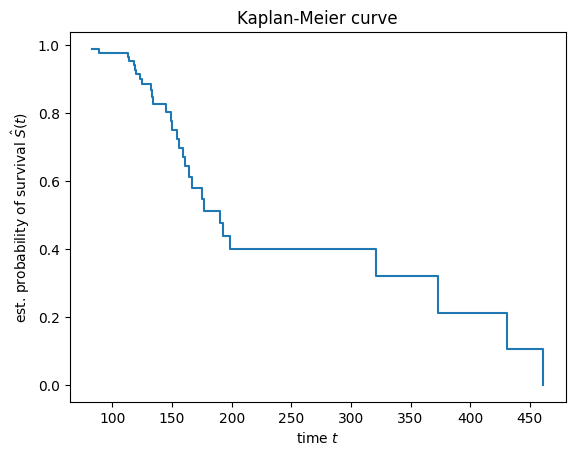

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
time, survival_prob = kaplan_meier_estimator(y["Event"], y["TTE"])
plt.step(time, survival_prob, where="post")
plt.title("Kaplan-Meier curve")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

In [71]:
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from tools.evaluator import LifelinesEvaluator

t_train, e_train = split_time_event(y_train)
t_test, e_test = split_time_event(y_test)
event_times = make_event_times(t_train, e_train)

rsf = RandomSurvivalForest(n_estimators=100, max_depth=4, random_state=0).fit(X_train, y_train)
cph = CoxPHSurvivalAnalysis(alpha=0.0001).fit(X_train, y_train)
gbsa = GradientBoostingSurvivalAnalysis(n_estimators=100, max_depth=4, random_state=0).fit(X_train, y_train)

for model, model_name in zip([rsf, cph, gbsa], ['RSF', 'CPH', "GBSA"]):
    surv_preds = model.predict_survival_function(X_test)
    surv_preds = pd.DataFrame(np.row_stack([fn(event_times) for fn in surv_preds]), columns=event_times)
    lifelines_eval = LifelinesEvaluator(surv_preds.T, y_test["TTE"], y_test["Event"], t_train, e_train)
    mae_hinge = lifelines_eval.mae(method="Hinge")
    ci = lifelines_eval.concordance()[0]
    d_calib = lifelines_eval.d_calibration()[0]
    print(f"Evaluated {model_name}: CI={ci:.2f}, MAE={mae_hinge:.2f}, D-Calib={d_calib:.2f}")

Evaluated RSF: CI=0.58, MAE=45.99, D-Calib=0.99
Evaluated CPH: CI=0.67, MAE=74.31, D-Calib=0.89
Evaluated GBSA: CI=0.59, MAE=35.23, D-Calib=0.64


In [72]:
color

'#9467bd'

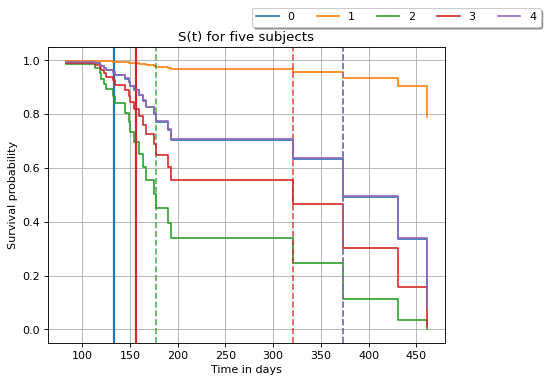

In [73]:
import matplotlib.pyplot as plt

n_samples = 5
X_test_sel = X_test.iloc[:n_samples]
y_test_sel = y_test[:n_samples]

surv = cph.predict_survival_function(X_test_sel, return_array=True)

styles = ('-', '--')
plt.figure(dpi=80)

for i, s in enumerate(surv):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.step(cph.unique_times_, s, where="post", label=str(i), color=color)
    
    try:
        # Find the time where the survival probability crosses 0.5
        crossing_index = next(x[0] for x in enumerate(s) if x[1] < 0.5)
        crossing_time = cph.unique_times_[crossing_index]
        
        # Plot vertical line at the crossing time with the same color as the curve
        plt.axvline(x=crossing_time, color=color, linestyle= "dashed", alpha=0.8)
    except:
        pass
    
    # Plot true event time
    if y_test_sel[i][0] == True:
        plt.axvline(x=y_test_sel[i][1], linewidth=2, color=color, alpha=1)
    
plt.title("S(t) for five subjects")
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend(bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [74]:
# Assuming your CoxPH model is stored in the variable `cph`
coefficients = cph.coef_
hazard_ratios = np.exp(coefficients)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': coefficients,
    'Hazard Ratio': hazard_ratios
})

# Convert hazard ratios to a formatted string
feature_importance_df['Hazard Ratio'] = feature_importance_df['Hazard Ratio'].apply(lambda x: f"{x:.4f}")

# Print the DataFrame
print(feature_importance_df)

                       Feature  Coefficient Hazard Ratio
0             Symptom_Duration     1.071967       2.9211
1             CNSLS_TotalScore     1.323286       3.7557
2  TAP_Fingertapping_Right_avg     3.894837      49.1480
3   TAP_Fingertapping_Left_avg    -2.195749       0.1113
4    TAP_Foottapping_Right_avg    -1.598164       0.2023
5     TAP_Foottapping_Left_avg    -0.698416       0.4974
6                    UMN_Right     2.845941      17.2178
7                     UMN_Left    -1.853562       0.1567
8                          Age     1.203025       3.3302
9                  SymptomDays     0.167324       1.1821


In [75]:
# Calculate SHAP values
import shap
explainer = shap.Explainer(rsf.predict, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 20it [01:37,  5.72s/it]                        


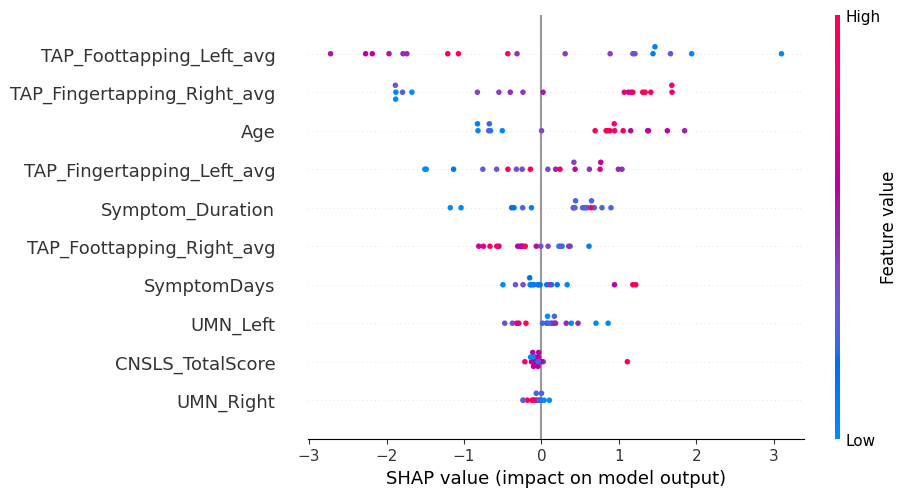

In [76]:
shap.plots.beeswarm(shap_values, show=False)
plt.show()

# PRO-ACT Dataset

In [77]:
file_name = "data_proact.csv"
df = pd.read_csv(Path.joinpath(cfg.DATA_DIR, file_name), index_col=0)
df = df.drop(['Speech_Observed', 'Speech_Event', 'Swallowing_Observed',
       'Swallowing_Event', 'Handwriting_Observed', 'Handwriting_Event'], axis=1)
df = df.rename({'Walking_Observed': 'TTE'}, axis=1)
df = df.rename({'Walking_Event': 'Event'}, axis=1)
df = df[df['TTE'] <= 1000] # max. 1000 days
df = df[df['TTE'] > 0] # min. 1 days.

In [78]:
nan_counts = df.isna().sum()
print(nan_counts)

TTE                                                  0
Event                                                0
SOO                                                  0
Diagnosis_Delta                                   1954
Subject_used_Riluzole                             1635
El_escorial                                       3437
FVC_Min                                           1443
FVC_Max                                           1443
FVC_Mean                                          1443
Handgrip_Strength                                 5191
ANKLE_Strength                                    5716
ELBOW_Strength                                    5704
FIRST_DORSAL_INTEROSSEOUS_OF_THE_HAND_Strength    5731
HIP_FLEXOR_Strength                               5707
KNEE_Strength                                     5700
SHOULDER_Strength                                 5829
WRIST_Strength                                    5705
dtype: int64


In [79]:
df.head()

,TTE,Event,SOO,Diagnosis_Delta,Subject_used_Riluzole,El_escorial,FVC_Min,FVC_Max,FVC_Mean,Handgrip_Strength,ANKLE_Strength,ELBOW_Strength,FIRST_DORSAL_INTEROSSEOUS_OF_THE_HAND_Strength,HIP_FLEXOR_Strength,KNEE_Strength,SHOULDER_Strength,WRIST_Strength
1,366.0,True,Limb,302.0,Yes,Probable Laboratory Supported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,957.0,False,LimbAndBulbar,44.0,NaN,Probable Laboratory Supported,1.57,1.76,1.686667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,False,Limb,507.0,No,Probable Laboratory Supported,0.84,1.10,0.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,63.0,True,Other,49.0,Yes,Probable Laboratory Supported,2.36,2.54,2.446667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,189.0,True,Limb,NaN,Yes,NaN,4.00,4.00,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
obs_arr = np.array(df['Event'])
n_censored = obs_arr.shape[0] - obs_arr.sum()
print(f"Number of samples: {len(df)}")
print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 6167
Number of censored/uncensored: 971/5196
15.75% of records are censored



In [81]:
# Load data
X = df.drop(['Event', 'TTE'], axis=1)
y = np.array(list(tuple(x) for x in df[['Event', 'TTE']].to_numpy()),
             dtype=[('Event', 'bool'), ('TTE', '<f8')])

# Select features
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(['object']).columns.tolist()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
feature_names = X_train.columns

# Preprocess dat
from tools.preprocessor import Preprocessor
preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean', scaling_strategy="minmax")
transformer = preprocessor.fit(X_train, cat_feats=cat_features, num_feats=num_features,
                               one_hot=True, fill_value=-1)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

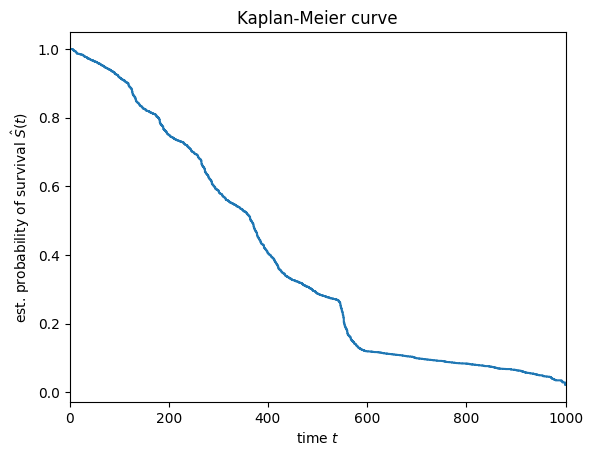

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
time, survival_prob = kaplan_meier_estimator(y["Event"], y["TTE"])
plt.step(time, survival_prob, where="post")
plt.xlim([0, 1000])
plt.title("Kaplan-Meier curve")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

In [83]:
t_train, e_train = split_time_event(y_train)
t_test, e_test = split_time_event(y_test)
event_times = make_event_times(t_train, e_train)

rsf = RandomSurvivalForest(n_estimators=100, max_depth=4, random_state=0).fit(X_train, y_train)
cph = CoxPHSurvivalAnalysis(alpha=0.0001).fit(X_train, y_train)
gbsa = GradientBoostingSurvivalAnalysis(n_estimators=100, max_depth=4, random_state=0).fit(X_train, y_train)

for model, model_name in zip([rsf, cph, gbsa], ['RSF', 'CPH', "GBSA"]):
    surv_preds = model.predict_survival_function(X_test)
    surv_preds = pd.DataFrame(np.row_stack([fn(event_times) for fn in surv_preds]), columns=event_times)
    lifelines_eval = LifelinesEvaluator(surv_preds.T, y_test["TTE"], y_test["Event"], t_train, e_train)
    mae_hinge = lifelines_eval.mae(method="Hinge")
    ci = lifelines_eval.concordance()[0]
    d_calib = lifelines_eval.d_calibration()[0]
    print(f"Evaluated {model_name}: CI={ci:.2f}, MAE={mae_hinge:.2f}, D-Calib={d_calib:.2f}")

Evaluated RSF: CI=0.58, MAE=158.62, D-Calib=0.48
Evaluated CPH: CI=0.55, MAE=162.41, D-Calib=0.05
Evaluated GBSA: CI=0.61, MAE=155.00, D-Calib=0.01


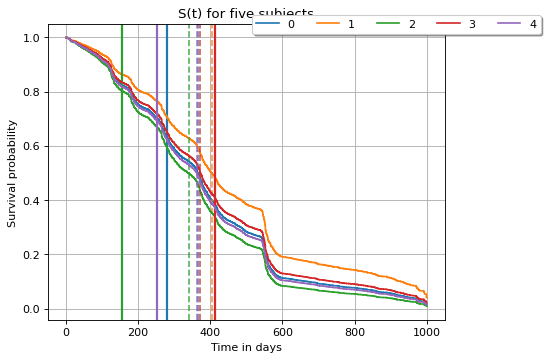

In [84]:
import matplotlib.pyplot as plt

n_samples = 5
X_test_sel = X_test.iloc[:n_samples]
y_test_sel = y_test[:n_samples]

surv = cph.predict_survival_function(X_test_sel, return_array=True)

styles = ('-', '--')
plt.figure(dpi=80)

for i, s in enumerate(surv):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.step(cph.unique_times_, s, where="post", label=str(i), color=color)
    
    # Find the time where the survival probability crosses 0.5
    crossing_index = next(x[0] for x in enumerate(s) if x[1] < 0.5)
    crossing_time = cph.unique_times_[crossing_index]
    
    # Plot vertical line at the crossing time with the same color as the curve
    plt.axvline(x=crossing_time, color=color, linestyle= "dashed", alpha=0.8)
    
    # Plot true event time
    if y_test_sel[i][0] == True:
        plt.axvline(x=y_test_sel[i][1], linewidth=2, color=color, alpha=1)
    
plt.title("S(t) for five subjects")
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend(bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [85]:
# Assuming your CoxPH model is stored in the variable `cph`
coefficients = cph.coef_
hazard_ratios = np.exp(coefficients)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': coefficients,
    'Hazard Ratio': hazard_ratios
})

# Convert hazard ratios to a formatted string
feature_importance_df['Hazard Ratio'] = feature_importance_df['Hazard Ratio'].apply(lambda x: f"{x:.4f}")

# Print the DataFrame
print(feature_importance_df)

                                           Feature  Coefficient Hazard Ratio
0                                  Diagnosis_Delta     1.062376       2.8932
1                                          FVC_Min    -1.529902       0.2166
2                                          FVC_Max    -0.498430       0.6075
3                                         FVC_Mean     0.788369       2.1998
4                                Handgrip_Strength     0.954205       2.5966
5                                   ANKLE_Strength    -1.409702       0.2442
6                                   ELBOW_Strength    -0.466525       0.6272
7   FIRST_DORSAL_INTEROSSEOUS_OF_THE_HAND_Strength    -0.556605       0.5732
8                              HIP_FLEXOR_Strength    -1.431053       0.2391
9                                    KNEE_Strength     2.374269      10.7432
10                               SHOULDER_Strength     0.674454       1.9630
11                                  WRIST_Strength    -0.196509       0.8216

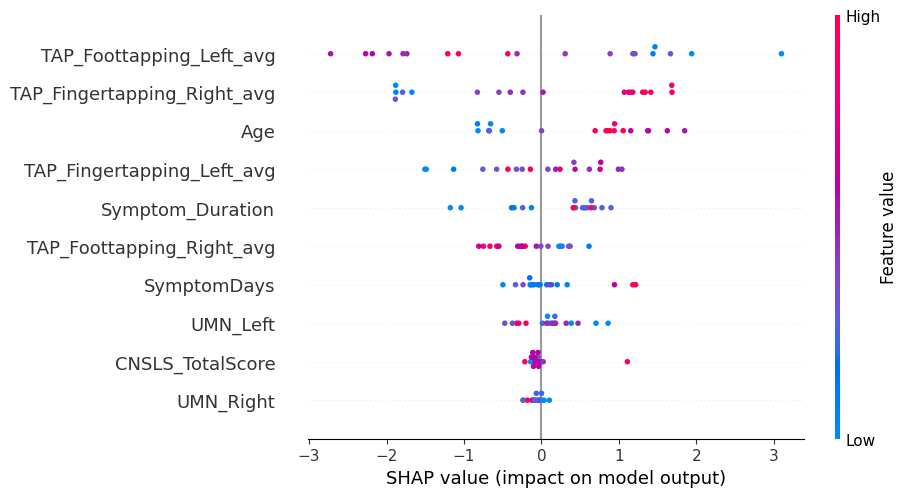

In [86]:
shap.plots.beeswarm(shap_values, show=False)
plt.show()

# PROACT No muscle data

In [87]:
# Select non-muscle test data
df = df[['TTE', 'Event', 'SOO', 'Diagnosis_Delta', 'Subject_used_Riluzole',
         'El_escorial', 'FVC_Min', 'FVC_Max', 'FVC_Mean']]

In [88]:
df.head()

,TTE,Event,SOO,Diagnosis_Delta,Subject_used_Riluzole,El_escorial,FVC_Min,FVC_Max,FVC_Mean
1,366.0,True,Limb,302.0,Yes,Probable Laboratory Supported,NaN,NaN,NaN
2,957.0,False,LimbAndBulbar,44.0,NaN,Probable Laboratory Supported,1.57,1.76,1.686667
3,3.0,False,Limb,507.0,No,Probable Laboratory Supported,0.84,1.10,0.950000
6,63.0,True,Other,49.0,Yes,Probable Laboratory Supported,2.36,2.54,2.446667
8,189.0,True,Limb,NaN,Yes,NaN,4.00,4.00,4.000000


In [89]:
# Load data
X = df.drop(['Event', 'TTE'], axis=1)
y = np.array(list(tuple(x) for x in df[['Event', 'TTE']].to_numpy()),
             dtype=[('Event', 'bool'), ('TTE', '<f8')])

# Select features
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(['object']).columns.tolist()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
feature_names = X_train.columns

# Preprocess dat
from tools.preprocessor import Preprocessor
preprocessor = Preprocessor(cat_feat_strat='mode', num_feat_strat='mean', scaling_strategy="minmax")
transformer = preprocessor.fit(X_train, cat_feats=cat_features, num_feats=num_features,
                               one_hot=True, fill_value=-1)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [90]:
t_train, e_train = split_time_event(y_train)
t_test, e_test = split_time_event(y_test)
event_times = make_event_times(t_train, e_train)

rsf = RandomSurvivalForest(n_estimators=100, max_depth=4, random_state=0).fit(X_train, y_train)
cph = CoxPHSurvivalAnalysis(alpha=0.0001).fit(X_train, y_train)
gbsa = GradientBoostingSurvivalAnalysis(n_estimators=100, max_depth=4, random_state=0).fit(X_train, y_train)

for model, model_name in zip([rsf, cph, gbsa], ['RSF', 'CPH', "GBSA"]):
    surv_preds = model.predict_survival_function(X_test)
    surv_preds = pd.DataFrame(np.row_stack([fn(event_times) for fn in surv_preds]), columns=event_times)
    lifelines_eval = LifelinesEvaluator(surv_preds.T, y_test["TTE"], y_test["Event"], t_train, e_train)
    mae_hinge = lifelines_eval.mae(method="Hinge")
    ci = lifelines_eval.concordance()[0]
    d_calib = lifelines_eval.d_calibration()[0]
    print(f"Evaluated {model_name}: CI={ci:.2f}, MAE={mae_hinge:.2f}, D-Calib={d_calib:.2f}")

Evaluated RSF: CI=0.56, MAE=159.87, D-Calib=0.27
Evaluated CPH: CI=0.54, MAE=163.92, D-Calib=0.24
Evaluated GBSA: CI=0.58, MAE=158.93, D-Calib=0.00


# Using muscle strength test
Evaluated RSF: CI=0.58, MAE=158.62, D-Calib=0.48<br>
Evaluated CPH: CI=0.55, MAE=162.41, D-Calib=0.05<br>
Evaluated GBSA: CI=0.61, MAE=155.00, D-Calib=0.01<br>

In [91]:
# Assuming your CoxPH model is stored in the variable `cph`
coefficients = cph.coef_
hazard_ratios = np.exp(coefficients)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': coefficients,
    'Hazard Ratio': hazard_ratios
})

# Convert hazard ratios to a formatted string
feature_importance_df['Hazard Ratio'] = feature_importance_df['Hazard Ratio'].apply(lambda x: f"{x:.4f}")

# Print the DataFrame
print(feature_importance_df)

                                     Feature  Coefficient Hazard Ratio
0                            Diagnosis_Delta     1.043105       2.8380
1                                    FVC_Min    -1.398146       0.2471
2                                    FVC_Max    -1.307727       0.2704
3                                   FVC_Mean     1.517638       4.5614
4                          SOO_LimbAndBulbar    -0.314122       0.7304
5                                  SOO_Other     0.214603       1.2394
6                  Subject_used_Riluzole_Yes     0.181877       1.1995
7                       El_escorial_Possible    -0.137999       0.8711
8                       El_escorial_Probable     0.097341       1.1022
9  El_escorial_Probable Laboratory Supported     0.035213       1.0358
